In [1]:
# imports
import os
os.environ['R_HOME'] = 'C:\\Users\\093637\\AppData\\Local\\Programs\\R\\R-4.3.1'

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index as cindex
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [2]:
dataset_raw = pd.read_spss("W:\Cohort_TCGA\TCGA_clinical_data.sav").set_index('PatientNr')
dataset_raw.head()

,StudyID,EMCcohort,IncludedInPreviousModel,Tissue,TumorSize,Tumor4cmOrLarger,RTI,LVI_TCGA,LVI,NeoadjuvantChemotherapy,...,RTIstromal,RTIpagetoid,LymphovascularInvastion,PercentageRegression,InvasionEpididymis,InvasionParatesticularTissue,InvasionTunicaVaginalis,InvasionSpermaticCord,SurgicalMargin,Treatments
PatientNr,,,,,,,,,,,,,,,,,,,,,
AAEW,TCGA-2G-AAEW,,No,Testis,6.0,Yes,Yes,1.0,Yes,NaN,...,NaN,NaN,Yes,NaN,No,No,,No,No,
AAEX,TCGA-2G-AAEX,,No,Testis,7.0,Yes,No,0.0,No,NaN,...,NaN,NaN,No,NaN,No,No,,No,No,
AAF1,TCGA-2G-AAF1,,No,Testis,6.5,Yes,Yes,1.0,Yes,NaN,...,NaN,NaN,NaN,NaN,No,No,,No,No,
AAF4,TCGA-2G-AAF4,,No,Testis,6.0,Yes,Yes,1.0,Yes,NaN,...,NaN,NaN,NaN,NaN,No,No,,No,No,
AAF6,TCGA-2G-AAF6,,No,Testis,6.0,Yes,No,0.0,No,NaN,...,NaN,NaN,NaN,NaN,No,No,,No,No,


In [6]:
drop_columns = [
    'StudyID',
    'EMCcohort',
    'IncludedInPreviousModel',
    'Tissue',
    'PureSeminoma',
    'NonSeminomaSubtype',
    'Comment',
    'Treatments',
    'ChemotherapyAtDiagnosis', # Not sure if to drop this
    'InvasionEpididymis',
    'TimingMetastases', # model cannot see this
    'Death',
    'DiseaseRelatedDeath',
    'InvasionTunicaVaginalis',
    'InvasionSpermaticCord',
    # 'InvasionParatesticularTissue',
    'SurgicalMargin',
    'TimetoDeathOrEFU',
    'NeoadjuvantChemotherapy',
    'Syncytiotrofoblast'
]



continuous_columns = [
    'TumorSize',
    # 'PercentageNecrosis',
    # 'PercentageRegression'
]

# dataset_processed = dataset_raw.drop(drop_columns, axis=1)
# dataset_processed.Metastases = dataset_processed.Metastases.replace({'Yes': 1, 'No': 0}).astype(int)
dataset_processed = dataset_raw[['TimetoMetastasesOrEFU', 'Metastases', 'LVI', 'RTI', 'AdjuvantTreatment', 'TumorSize']].replace({'Yes': 1, 'No': 0}).dropna(axis=0).copy()
dataset_processed.head(5)

for col in dataset_processed:
    if dataset_processed[col].dtype == 'category':
        dataset_processed[col] = dataset_processed[col].cat.codes.astype(int)

dataset_processed.fillna(0, inplace=True)
dataset_processed.drop((dataset_processed[dataset_processed['TimetoMetastasesOrEFU'] < 0]).index, axis=0, inplace=True)

In [7]:
def to_one_hot(dataframe, columns):
    '''
    Convert columns in dataframe to one-hot encoding.
    Args:
        dataframe (dataframe): pandas dataframe containing covariates
        columns (list of strings): list categorical column names to one hot encode
    Returns:
        one_hot_df (dataframe): dataframe with categorical columns encoded
                            as binary variables
    '''
  
    one_hot_df = pd.get_dummies(dataframe, columns=columns, drop_first=True)
    
    return one_hot_df

In [7]:
# One hot
to_encode = [
    'LymphocyticInfiltration',
    # 'Syncytiotrofoblast',
    'TypeAdjuvantTreatment',
    #'TimingMetastases',
    'AdjuvantTreatment'
]

# dataset_one_hot = to_one_hot(dataset_processed, to_encode)
dataset_one_hot = dataset_processed.copy()

In [8]:
np.random.seed(12)
df_dev, df_test = train_test_split(dataset_one_hot, test_size = 0.2, stratify=dataset_one_hot['Metastases'])
df_train, df_val = train_test_split(df_dev, test_size = 0.25, stratify=df_dev['Metastases'])

# Unskew and normalize data
mean = np.log(df_train.loc[:, continuous_columns]+1).mean()
std = np.log(df_train.loc[:, continuous_columns]+1).std()
df_train.loc[:, continuous_columns] = (np.log(df_train.loc[:, continuous_columns]+1) - mean) / std
df_val.loc[:, continuous_columns] = (np.log(df_val.loc[:, continuous_columns]+1) - mean) / std
df_test.loc[:, continuous_columns] = (np.log(df_test.loc[:, continuous_columns]+1) - mean) / std

one_hot_train = df_train
one_hot_val = df_val
one_hot_test = df_test


In [9]:
one_hot_val.columns

Index(['TimetoMetastasesOrEFU', 'Metastases', 'LVI', 'RTI',
       'AdjuvantTreatment', 'TumorSize'],
      dtype='object')

In [191]:
cph = CoxPHFitter(penalizer=0.0001)
cph.fit(one_hot_train, duration_col = 'TimetoMetastasesOrEFU', event_col = 'Metastases', fit_options={'step_size':0.1})

<lifelines.CoxPHFitter: fitted with 25 total observations, 21 right-censored observations>

In [192]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 25 total observations, 21 right-censored observations>
             duration col = 'TimetoMetastasesOrEFU'
                event col = 'Metastases'
                penalizer = 0.0001
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 25
number of events observed = 4
   partial log-likelihood = -5.24
         time fit was run = 2023-09-27 09:28:52 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                 
LVI                -6.47       0.00      15.38           -36.63            23.68                 0.00             1.92e+10
RTI                 0.27       1.31       1.34            -2.35             2.89                 0.10                18.01
AdjuvantTreatment  -1.34       0.26       1.49            -4.27             1.59                 0.01                 4.92
TumorSize           0.43       1.53       0.74            -1.02             1.87                 0.36                 6.52

                    cmp to     z    p   -log2(p)
covariate                                       
LVI                   0.00 -0.42 0.67       0.57
RTI                   0.00  0.20 0.84       0.25
AdjuvantTreatment     0.00 -0.89 0.37       1.43
TumorSize             0.00  0.58 0.56       0.83
---
Concordance = 0.64
Partial AIC = 18.48
log-likelihood ratio test = 3.80 on 4 df
-log2(p) of ll-ratio test = 1.21

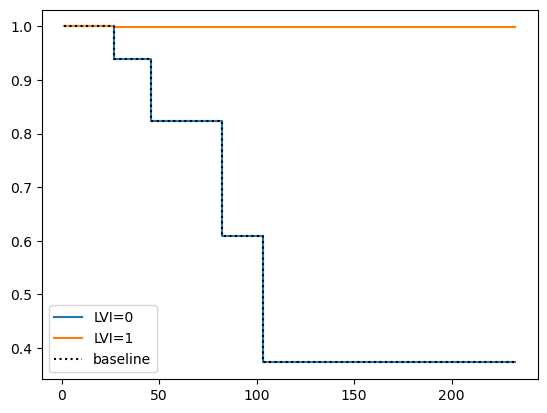

In [12]:
cph.plot_covariate_groups('LVI', values=[0, 1]);

In [13]:
scores = cph.predict_partial_hazard(one_hot_train)
cox_train_scores = cindex(one_hot_train['TimetoMetastasesOrEFU'].values, scores.values, one_hot_train['Metastases'].values)
# Validation
scores = cph.predict_partial_hazard(one_hot_val)
cox_val_scores = cindex(one_hot_val['TimetoMetastasesOrEFU'].values, scores.values, one_hot_val['Metastases'].values)
# Test
scores = cph.predict_partial_hazard(one_hot_test)
cox_test_scores = cindex(one_hot_test['TimetoMetastasesOrEFU'].values, scores.values, one_hot_test['Metastases'].values)

print("Train:", cox_train_scores)
print("Val:", cox_val_scores)
print("Test:", cox_test_scores)

Train: 0.36
Val: 0.9090909090909091
Test: 0.75


In [14]:
%load_ext rpy2.ipython
%R require(ggplot2)

from rpy2.robjects.packages import importr
# import R's "base" package
base = importr('base')

# import R's "utils" package
utils = importr('utils')

# import rpy2's package module
import rpy2.robjects.packages as rpackages

forest = rpackages.importr('randomForestSRC')

from rpy2 import robjects as ro
R = ro.r

from rpy2.robjects import pandas2ri
pandas2ri.activate()

c:\Users\093637\AppData\Local\anaconda3\envs\seminoma-relapse\Lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


Loading required package: ggplot2
RStudio Community is a great place to get help:
https://community.rstudio.com/c/tidyverse


In [15]:
print(base._libPaths())

['C:/Users/093637/AppData/Local/Programs/R/R-4.3.1/library']


In [82]:
df_dev, df_test = train_test_split(dataset_one_hot, test_size = 0.2, stratify=dataset_one_hot['Metastases'])
df_train, df_val = train_test_split(df_dev, test_size = 0.25, stratify=df_dev['Metastases'])

# Unskew and normalize data
mean = np.log(df_dev.loc[:, continuous_columns]+1).mean()
std = np.log(df_dev.loc[:, continuous_columns]+1).std()
df_train.loc[:, continuous_columns] = (np.log(df_train.loc[:, continuous_columns]+1) - mean) / std
df_val.loc[:, continuous_columns] = (np.log(df_val.loc[:, continuous_columns]+1) - mean) / std
df_test.loc[:, continuous_columns] = (np.log(df_test.loc[:, continuous_columns]+1) - mean) / std
df_dev.loc[:, continuous_columns] = (np.log(df_dev.loc[:, continuous_columns]+1) - mean) / std

In [50]:
df_dev_pos = df_dev[df_dev['Metastases'] == 1]

In [52]:
df_dev = pd.concat([df_dev, df_dev_pos])

In [84]:
model = forest.rfsrc(ro.Formula('Surv(TimetoMetastasesOrEFU, Metastases) ~.'), data=df_train, ntree=5, nodedepth=10)

In [85]:
result = R.predict(model, newdata=df_val)
scores = np.array(result.rx('predicted')[0])

print("Cox Model Validation Score:", cox_val_scores)
print("Survival Forest Validation Score:", cindex(df_val['TimetoMetastasesOrEFU'].values, scores, df_val['Metastases'].values))

Cox Model Validation Score: 0.9090909090909091
Survival Forest Validation Score: 0.5


In [79]:
df_dev = df_dev.astype(float)

In [88]:
result = R.predict(model, newdata=df_test)
scores = np.array(result.rx('predicted')[0])

print("Cox Model Test Score:", cox_test_scores)
print("Survival Forest Validation Score:", cindex(df_test['TimetoMetastasesOrEFU'].values, scores, df_test['Metastases'].values))

Cox Model Test Score: 0.75
Survival Forest Validation Score: 0.5


In [92]:
forest.vimp(model).rx('importance')[0]

array([0., 0., 0., 0.])

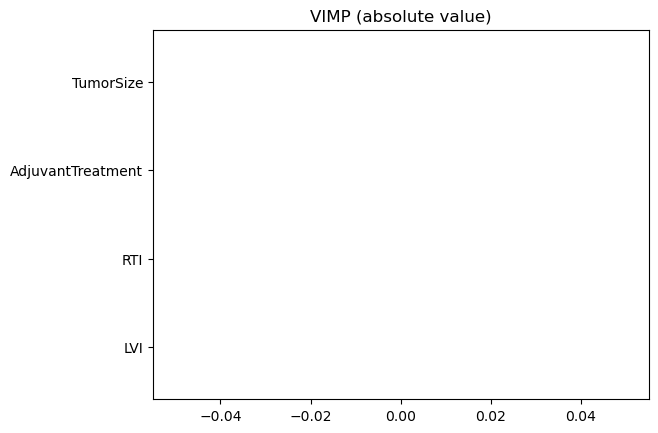

In [89]:
vimps = np.array(forest.vimp(model).rx('importance')[0])

y = np.arange(len(vimps))
plt.barh(y, np.abs(vimps))
plt.yticks(y, df_train.drop(['TimetoMetastasesOrEFU', 'Metastases'], axis=1).columns)
plt.title("VIMP (absolute value)")
plt.show()

In [153]:
from sksurv.tree import SurvivalTree

In [164]:
tree = SurvivalTree(max_depth=4)

In [172]:

# Iterate over the rows and create tuples
y_train = np.array([(a, b) for a, b in zip(df_dev['Metastases'], df_dev['TimetoMetastasesOrEFU'])], dtype='bool,f')

In [166]:
tree.fit(df_dev.drop(columns=['TimetoMetastasesOrEFU', 'Metastases']), y)

SurvivalTree(max_depth=4)

In [167]:
tree.score(df_dev.drop(columns=['TimetoMetastasesOrEFU', 'Metastases']), y)

0.8108108108108109

In [171]:
y_val = np.array([(a, b) for a, b in zip(df_test['Metastases'], df_test['TimetoMetastasesOrEFU'])], dtype='bool,f')

tree.score(df_test.drop(columns=['TimetoMetastasesOrEFU', 'Metastases']), y_val)

0.0

In [143]:
test_datset = pd.read_spss('W:\Cohort_EMC\WSIproject_StageI_Anonymized.sav')

dataset_cox_test = test_datset[['TimetoMetastasesOrEFU', 'Metastases', 'LVI', 'RTI', 'AdjuvantTreatment', 'TumorSize']].replace({'Yes': 1, 'No': 0}).dropna(axis=0)

In [144]:
y_test = np.array([(a, b) for a, b in zip(dataset_cox_test['Metastases'], dataset_cox_test['TimetoMetastasesOrEFU'])], dtype='bool,f')

In [145]:
tree.score(dataset_cox_test.drop(columns=['TimetoMetastasesOrEFU', 'Metastases']), y_test)

0.5643491124260355

In [170]:
X_train = df_dev.drop(columns=['TimetoMetastasesOrEFU', 'Metastases'])
X_val = df_test.drop(columns=['TimetoMetastasesOrEFU', 'Metastases'])

In [186]:
from sksurv.tree import SurvivalTree
from sklearn.model_selection import GridSearchCV, train_test_split
from sksurv.metrics import concordance_index_censored

param_grid = {
    'max_depth': [None, 10, 20],  # Specify the values you want to try for max_depth
    'min_samples_split': [2, 5, 10]  # Specify the values you want to try for min_samples_split
}

# Create the SurvivalTree model
tree = SurvivalTree()

# Initialize GridSearchCV
grid_search = GridSearchCV(tree, param_grid, cv=3, n_jobs=-1)

# Fit the model using the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", -grid_search.best_score_)

Best parameters found:  {'max_depth': None, 'min_samples_split': 2}
Best score found:  -0.5956439393939394


In [187]:
tree = SurvivalTree(max_depth=None, min_samples_split=2)
tree.fit(X_train, y_train)

SurvivalTree(min_samples_split=2)

In [188]:
tree.score(X_train, y_train)

0.8243243243243243

In [189]:
tree.score(X_val, y_val)

0.25